<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>Save, compress, and deploy a handwritten digit prediction Keras model</b></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/scikit-learn/hand-written-digits-recognition/images/numbers_banner-04.png" width="600" alt="Icon"></td>
   </tr>
</table>

This notebook demonstrates how to train, deploy, and score a Deep Learning model using the Watson Machine Learning. Specifically, it shows you how to save the trained Deep Learning model as a `.tgz` file locally and deploy it. 

This notebooks uses `keras 2.2.5` and `watson-machine-learning-client-V4`.

Some familiarity with Python is helpful. This notebook is compatible with CP4D 3.0 and Python 3.6.


## Learning goals

In this notebook, you will learn how to use Watson Machine Learning to save, deploy, and score a Deep Learning (Keras) model through these steps:

- Build a Deep Learning (Keras) model and train it.
- Save the trained model as a `.tgz` file in a deployment space.
- Create a batch deployment of the trained model and score it.


## Table of Contents

1.	[Setting up](#setup)
2.	[Explore data](#data)<br>
    2.1   [Import the data](#import_the_data)<br>
    2.2   [Display the data](#display_the_data)<br>
    2.3   [Shape the data](#shape_the_data)<br>
3.  [Train and evaluate the model](#train)<br>
    3.1   [Train the model](#train_sub)<br>
    3.2   [Evaluate the model](#evaluate_model)<br>
4.	[Save the model](#save)<br>
    4.1   [Save the model locally](#savelocal)<br>
    4.1   [Save the model in your project or deployment space](#save_pyclient)<br>
5.	[Create a batch deployment (with deployment space only)](#deploy)
6.	[Score data](#score)
7.	[Summary and next steps](#summary)

To get started on CP4D 3.0, find documentation on installation and set up <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/cpd/overview/welcome.html" target="_blank" rel="noopener no referrer">here</a>.

<a id="setup"></a>
## 1. Setting up

Local Python environment configurations:
  + Python 3.6
  + Keras 2.2.5
  + watson-machine-learning-client-V4 *(run code below to install)*
  + matplotlib *(run code below to install)*<br>

**Authenticate the Python client on CP4D 3.0.**<br><br>

<div class="alert alert-block alert-info">To find your authentication information (your credentials) follow the steps provided here in the <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/ml-authentication-local.html" target="_blank" rel="noopener no referrer">Documentation.</a></div>

**Action**: Enter your credentials in the following cell.

In [1]:
# Enter your credentials here
import sys,os,os.path
token = os.environ['USER_ACCESS_TOKEN']

from project_lib.utils import environment
url = environment.get_common_api_url()

wml_credentials = {
"token": token,
"instance_id" : "wml_local",
"url": url,
"version": "3.0.0"
}

Import the `watson-machine-learning-client` module.
<div class="alert alert-block alert-info">
For more information about the <b>Watson Machine Learning Python client (V4)</b>, please refer to the <a href="https://wml-api-pyclient-dev-v4.mybluemix.net/" target="_blank" rel="noopener no referrer">Python client documentation</a>. If you're using the notebook within a project on your CP4D cluster, you do not need to install this package as it comes pre-installed with the notebooks. The installation code below is for demonstration but is non-executable at this stage.
</div>

In [2]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [3]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [4]:
client.version

'1.0.64'

<div class="alert alert-block alert-info">
You have a choice to either save the model in the <b>project</b> or the <b>deployment space</b>:<br><br>
    <li> If you're saving your model in your project, you have to set the default project using the python client.</li><br>
    <li>If you're saving the model in the deployment space, you have to obtain the space UID of the deployment space you've created. Then you'd use this to set the default space using the python client. From there you'll be able to deploy and score the model in your deployment space.</li></div>

### To set the default project, use the following code.

In [6]:
from project_lib import Project
project = Project.access()
project_id = project.get_metadata()["metadata"]["guid"]

client.set.default_project(project_id)

'SUCCESS'

### To set the default space, follow these steps.

<div class="alert alert-block alert-info">
You can create your own <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/ml-spaces_local.html" target="_blank" rel="noopener no referrer">deployment space</a> by selecting <b>Analytics deployments</b> under <b>Analyze</b> from the Navigation Menu on the top left of this page.</div>

Alternatively, you can create a deployment and obtain its UID using the code in the following cell. The cell is not executable cell at this stage, but you can enter the name of your space in the metadata and use it if needed.

In [5]:
# Obtain the UID of your space
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['guid'])

**Action:** Enter the name of your deployment space in the code below: `space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')`.

In [6]:
# Enter the name of your deployment space here:
space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')
print("Space UID = " + space_uid)

Space UID = d0370894-81c8-42cd-afe0-3bca30cd121c


You can set the default space using the cell below.

In [7]:
client.set.default_space(space_uid)

'SUCCESS'

## 2. Explore the data <a id="data"></a>

In this section, you check what the input data looks like before using them to train the model.
You need the modules `keras.datasets.mnist` and `matplotlib.pyplot` to see what each digit looks like.

### 2.1 Import the data <a id="import_the_data"></a>

Import the MNIST data set from the `keras.datasets.mnist` module and split the data set into training and test data sets.

In [8]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
!pip install --upgrade keras==2.2.5

In [10]:
import keras
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Import `matlplotlib.pyplot`.

In [11]:
import matplotlib.pyplot as plt

### 2.2 Display the Data <a id="display_the_data"></a>

In [12]:
'''
Parameters of "display_digits" function:

plt     - matplotlib's pyplot module.
images  - The array of images. Ex) X_train, X_test in our example
labels  - Labels of mapping images. 
start   - Start index of "images" array.
end     - End index of "images" array.
num_row - Number of rows.
title   - Title of every image that will be displayed. E.g. 'Training' or 'Test'
'''
def display_digits(plt, images, labels, start, end, num_row, title):
    images_and_labels = list(zip(images, labels))
    num_col = int(end/num_row) if (end % 2 == 0) else int(end/num_row) + 1

    for index, (image, label) in enumerate(images_and_labels[start:end]):
        plt.subplot(num_row, num_col, index + 1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(title + ': %i' % label)

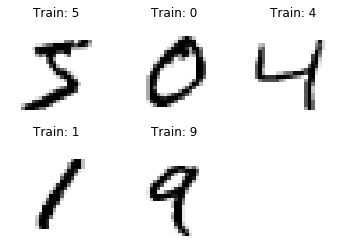

In [13]:
display_digits(plt, X_train, y_train, 0, 5, 2, 'Train')

### 2.3 Shape the Data <a id="shape_the_data"></a>

Check the shapes of the training and test data sets as well as the corresponding label arrays.

In [14]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


Save copies of `X_test` and `y_test` for scoring in the [Score](#score) section before reshaping them in the [Training](#train_sub) section.

In [15]:
X_test_score = X_test.copy()
y_test_score = y_test.copy()

## 3. Train and evaluate the model <a id="train"></a>

In this section, you will build a Deep Learning (Keras) model, train it, and evaluate it.

Import the required package and modules.

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

### 3.1 Train the model <a id="train_sub"></a>

Set the parameters that are required for the Deep Learning (Keras) model.

In [17]:
batch_size = 128
num_classes = 10
epochs = 6

As you have seen in the section [Explore the data](#data), the image size is 28x28 pixels.

In [18]:
img_rows, img_cols = 28, 28

In [19]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Scale the digits to be of range [0-1] instead of [0-255].

In [20]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Convert the label arrays of training/test digit images into one hot format matrix.

Ex)  
0 => [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
1 => [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  
.  
.  
.  

In [21]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#### 3.1.1 Layers in the model <a id="layers_model"></a>

- Conv2D layer
    - The first 2D convolution layer has 32 output filters and the second 2D convolution layer has 64 output filters.
    - `kernel_size` specifies the height and width of the 2D convolution window.
    - `activation` is a non-linear function that applies to the output of the layer. `relu` (rectified linear unit) clamps all values below 0 to 0.
- MaxPooling layer
    - Max pooling basically moves a `m`x`n` window across a 2D input space where `m` and `n` are both 2 in this example. The max value within the window is the output.
- Dropout layer
    - Helps the model avoid overfitting.
- Dense layer
    - A regular densely connected neural network layer.
- Flatten layer
    - Flattens the input and doesn't affect the batch size.
- Adadelta 
    - Adapts learning rates based on a moving window of gradient updates instead of accumulating all past gradients. This way, Adadelta continues learning even when many updates occur.

In [24]:
model = Sequential()
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Train the model with the parameters you just set.

In [25]:
history = model.fit(X_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 272s 5ms/step - loss: 0.2649 - acc: 0.9186 - val_loss: 0.0614 - val_acc: 0.9796
Epoch 2/6
60000/60000 [==============================] - 274s 5ms/step - loss: 0.0917 - acc: 0.9725 - val_loss: 0.0438 - val_acc: 0.9861
Epoch 3/6
60000/60000 [==============================] - 272s 5ms/step - loss: 0.0683 - acc: 0.9801 - val_loss: 0.0343 - val_acc: 0.9878
Epoch 4/6
60000/60000 [==============================] - 266s 4ms/step - loss: 0.0554 - acc: 0.9835 - val_loss: 0.0310 - val_acc: 0.9889
Epoch 5/6
60000/60000 [==============================] - 268s 4ms/step - loss: 0.0484 - acc: 0.9851 - val_loss: 0.0294 - val_acc: 0.9897
Epoch 6/6
60000/60000 [==============================] - 265s 4ms/step - loss: 0.0416 - acc: 0.9877 - val_loss: 0.0294 - val_acc: 0.9901


Plot the model accuracy on the train and validation (test) data sets. With the given code, the graphs are plotted in `R`'s `ggplot` style.

In [26]:
plt.style.use('ggplot')

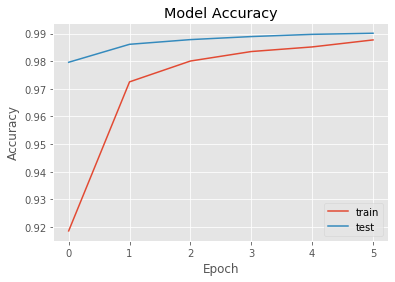

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')

Plot the model loss on the train and validation (test) data sets.

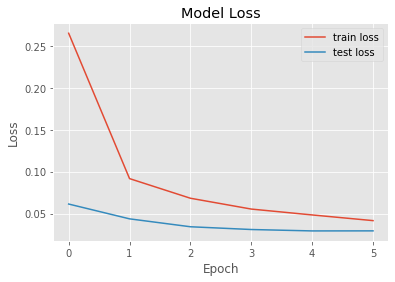

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'test loss'], loc='upper right')

### 3.2 Evaluate the model <a id="evaluate_model"></a>

In this section, you evaluate the model and score its accuracy.

In [29]:
score = model.evaluate(X_test, y_test, verbose=0)

In [30]:
print('Test loss:', score[0])
print('Test accuracy: {:.2f}%'.format(score[1]*100))

Test loss: 0.029440266271845393
Test accuracy: 99.01%


## 4. Save the model <a id="save"></a>

### 4.1 Save the model locally <a id="savelocal"></a>

In this section, you will learn how to save the trained Deep Learning (Keras) model locally and compress it into a `.tgz` file.

First, save the Keras model locally.

In [31]:
from contextlib import suppress
import os

filename = 'keras_mnist_model.h5'

# Delete a duplicate file if exists.
with suppress(OSError):
    os.remove(filename)
    
model.save(filename)

Compress the Keras model file into a `.tgz` file. Make sure to add the `z` flag when running the `tar` command.

In [32]:
#compress keras model
tar_filename = filename + '.tgz'
cmdstring = 'tar -zcvf ' + tar_filename + ' ' + filename
os.system(cmdstring)

0

You can see that the model file `keras_mnist_model.h5` and its compressed version `keras_mnist_model.h5.tgz` are both saved in the local file system.

In [33]:
!ls

keras_mnist_model.h5  keras_mnist_model.h5.tgz


### 4.2 Save the model in your project or deployment space <a id="save_pyclient"></a>

Define the metadata for the trained model made in the section [Train and evaluate the model](#train).

In [46]:
#Model Metadata
software_spec_uid = client.software_specifications.get_uid_by_name("tensorflow_1.15-py3.6")

meta_props={
    client.repository.ModelMetaNames.NAME: "MNIST - compressed keras model",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    client.repository.ModelMetaNames.TYPE: "keras_2.2.5"
}

<div class="alert alert-block alert-info">To list the supported software specifications, run <tt>client.software_specifications.list()</tt>.<br>To find more information about the frameworks with their respective <b>Types</b> and <b>Software Specifications</b>, visit the <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/wmls/wmls-deploy-python-types.html" target="_blank" rel="noopener no referrer">documentation</a>.</div>

Get the `UID` for the trained model.

In [47]:
# Create the model artifact.
model_artifact = client.repository.store_model(tar_filename,
                                                   meta_props=meta_props,
                                                   training_data=X_train,
                                                   training_target=y_train)
model_uid = client.repository.get_model_uid(model_artifact)
print("Model UID = " + model_uid)

Model UID = 75824f7b-e8c0-4feb-8cab-f7e5455bd93a


Get the saved model metadata using the model UID.

In [48]:
# Details about the model.
model_details = client.repository.get_details(model_uid)
from pprint import pprint
pprint(model_details)

{'entity': {'content_status': {'state': 'persisted'},
            'name': 'MNIST - compressed keras model',
            'software_spec': {'id': '2b73a275-7cbf-420b-a912-eae7f436e0bc'},
            'space': {'href': '/v4/spaces/0ffd2e8c-d1a3-407a-9909-d20d9053ddee',
                      'id': '0ffd2e8c-d1a3-407a-9909-d20d9053ddee'},
            'type': 'keras_2.2.5'},
 'metadata': {'created_at': '2020-03-18T19:11:34.002Z',
              'guid': '75824f7b-e8c0-4feb-8cab-f7e5455bd93a',
              'href': '/v4/models/75824f7b-e8c0-4feb-8cab-f7e5455bd93a?space_id=0ffd2e8c-d1a3-407a-9909-d20d9053ddee',
              'id': '75824f7b-e8c0-4feb-8cab-f7e5455bd93a',
              'modified_at': '2020-03-18T19:11:36.002Z',
              'name': 'MNIST - compressed keras model',
              'owner': '1000330999',
              'space_id': '0ffd2e8c-d1a3-407a-9909-d20d9053ddee'}}


You can list all stored models using the `list_models` method.

In [8]:
# Display a list of all the models.
client.repository.list_models()

------------------------------------  ------------------------------  ------------------------  -----------
GUID                                  NAME                            CREATED                   TYPE
2a4144b6-52e2-4940-941c-685557aa885e  MNIST - compressed keras model  2020-03-20T15:33:18.002Z  keras_2.2.5
------------------------------------  ------------------------------  ------------------------  -----------


<div class="alert alert-block alert-info">
From the list of stored models, you can see that model is successfully saved.<br><br>
If you've set the default project, this means you've saved the model in your project. You can see the saved model in your project UI by clicking on your project name in the breadcrumb at the top of the application.<br><br>
If you've set the default space, this means that you've saved the model in your deployment space. You can view your model by selecting <b>Analytics Deployments</b> under <b>Analyze</b> from the Navigation Menu and clicking on your deployment space name.</div>

If you're using a deployment space, proceed to Section 5: [Create a batch deployment (with deployment space only)](#deploy). If not, you may skip to the [summary](#summary).

## 5. Create a batch deployment (with deployment space only) <a id="deploy"></a>

In this section, you learn how to create a <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/deploy-batch-jobs.html" target="_blank" rel="noopener no referrer">batch deployment</a> of the compressed version, which is the `.tgz` file, of the trained model described in the section [Save the model](#save).

Now, you can deploy the stored model as a batch deployment by running the following code.

In [22]:
# Deployment metadata.
deploy_meta = {
    client.deployments.ConfigurationMetaNames.NAME: "Keras MNIST model deployment through compressed file.",
    client.deployments.ConfigurationMetaNames.BATCH: {},
    client.deployments.ConfigurationMetaNames.HARDWARE_SPEC: {"name": "S", "num_nodes": 1}
}

In [23]:
# Create the deployment.
# model_uid = "2a4144b6-52e2-4940-941c-685557aa885e"
deployment_details = client.deployments.create(model_uid, meta_props=deploy_meta)



#######################################################################################

Synchronous deployment creation for uid: '2a4144b6-52e2-4940-941c-685557aa885e' started

#######################################################################################


ready.


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='ee3363e6-2f48-4cc1-b07d-4f56e2788d1f'
------------------------------------------------------------------------------------------------




Let's list the deployed models.

In [45]:
# List the deployments.
client.deployments.list()

------------------------------------  -----------------------------------------------------  -----  ------------------------  -------------
GUID                                  NAME                                                   STATE  CREATED                   ARTIFACT_TYPE
ee3363e6-2f48-4cc1-b07d-4f56e2788d1f  Keras MNIST model deployment through compressed file.  ready  2020-03-20T19:29:00.024Z  model
------------------------------------  -----------------------------------------------------  -----  ------------------------  -------------


<div class="alert alert-block alert-info">
From the list of deployed models, you can see that model was successfully deployed.</div>

In [25]:
# Deployment UID.
deployment_uid = client.deployments.get_uid(deployment_details)
print('Deployment uid = {}'.format(deployment_uid))

Deployment uid = ee3363e6-2f48-4cc1-b07d-4f56e2788d1f


## 6. Score data <a id="score"></a>

In this section, you learn how to score a test data record.

Prepare the scoring payload with the values to score, and save it as a zip file locally.

In [47]:
# Scoring payload - each record is a json
import json
input_jsons = [{"input_data": [{"values": [X_test[i].tolist()]}]} for i in range(5)]

# Save a json file containing each record
json_files = []
for i in range(len(input_jsons)):
    with open('keras_input_{}.json'.format(str(i)), 'w') as json_file:
        json.dump(input_jsons[i], json_file)
        json_files.append('keras_input_{}.json'.format(str(i)))

# Zip the 5 json files (5 records) into one input zip file
from zipfile import ZipFile
with ZipFile('keras_input_payload.zip','w') as zipf:
    for file in json_files:
        zipf.write(file)

In [48]:
ls

keras_input_0.json  keras_input_2.json  keras_input_4.json
keras_input_1.json  keras_input_3.json  keras_input_payload.zip


Use the following code to save the payload as a data asset in your deployment space.

In [49]:
asset_details = client.data_assets.create(name="keras_input_payload.zip", file_path="keras_input_payload.zip")

Creating data asset...
SUCCESS


Retrieve the URL of the stored asset.

In [50]:
asset_href = client.data_assets.get_href(asset_details)

Prepare the job payload that you'll use to score the batch deployment.

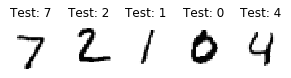

In [51]:
# Prepare job payload.
job_payload_asset = {
    client.deployments.ScoringMetaNames.INPUT_DATA_REFERENCES: [{
        "type": "data_asset",
        "connection": {},
        "location": {
            "href": asset_href
        },
    }],
    client.deployments.ScoringMetaNames.OUTPUT_DATA_REFERENCE: {
            "type": "data_asset",
            "connection": {},
            "location": {
                "name": "keras_results_{}.json".format(deployment_uid),
                "description": "results"
            }
        }
    }

display_digits(plt, X_test_score, y_test_score, 0, 5, 1, 'Test')

Use the following method to run the scoring.

In [52]:
job = client.deployments.create_job(deployment_id=deployment_uid, meta_props=job_payload_asset)
job_uid = client.deployments.get_job_uid(job)
print('Job uid = {}'.format(job_uid))

Job uid = bff49963-063c-4e21-b735-f05677549442


In [53]:
def poll_async_job(client, job_uid):
    import time
    while True:
        job_status = client.deployments.get_job_status(job_uid)
        print(job_status)
        state = job_status['state']
        if state == 'completed' or 'fail' in state:
            return client.deployments.get_job_details(job_uid)
        time.sleep(5)

In [54]:
# Perform prediction and display the result.

job_details_asset = poll_async_job(client, job_uid)
print(job_details_asset)

{'state': 'running', 'running_at': '2020-03-20T21:57:37.225Z', 'completed_at': ''}
{'state': 'running', 'running_at': '2020-03-20T21:57:37.225Z', 'completed_at': ''}
{'state': 'completed', 'running_at': '2020-03-20T21:57:37.212600Z', 'completed_at': '2020-03-20T21:57:51.725174Z'}
{'metadata': {'parent': {'href': ''}, 'guid': 'bff49963-063c-4e21-b735-f05677549442', 'id': 'bff49963-063c-4e21-b735-f05677549442', 'modified_at': '2020-03-20T21:57:51.805Z', 'created_at': '2020-03-20T21:57:02.220Z', 'href': '/v4/deployment_jobs/bff49963-063c-4e21-b735-f05677549442', 'space_id': 'd0370894-81c8-42cd-afe0-3bca30cd121c'}, 'entity': {'deployment': {'id': 'ee3363e6-2f48-4cc1-b07d-4f56e2788d1f', 'href': '/v4/deployments/ee3363e6-2f48-4cc1-b07d-4f56e2788d1f'}, 'space_id': 'd0370894-81c8-42cd-afe0-3bca30cd121c', 'scoring': {'input_data_references': [{'location': {'href': '/v2/assets/1427e3a1-bf06-4fd0-a8ee-43d59bf7e899?space_id=d0370894-81c8-42cd-afe0-3bca30cd121c'}, 'type': 'data_asset', 'connection'

You can see your that the `keras results` file has been created as a data asset.

In [55]:
client.data_assets.list()

-----------------------------------------------------------  ----------  -----  ------------------------------------
NAME                                                         ASSET_TYPE  SIZE   ASSET_ID
keras_results_ee3363e6-2f48-4cc1-b07d-4f56e2788d1f.json.zip  data_asset  928    9a47c02c-a7c0-46cd-bca8-ab5aa5525ed9
keras_input_payload.zip                                      data_asset  38312  1427e3a1-bf06-4fd0-a8ee-43d59bf7e899
-----------------------------------------------------------  ----------  -----  ------------------------------------


Get the UID of the results .zip file and download the data asset.

In [56]:
import re
results_asset = job_details_asset['entity']['scoring']['output_data_reference']['location']['href']
results_uid = re.split('[?/]', results_asset)[3]
results_uid

'9a47c02c-a7c0-46cd-bca8-ab5aa5525ed9'

In [57]:
client.data_assets.download(results_uid, "scoring_results.zip")

Successfully saved data asset content to file: 'scoring_results.zip'


'/home/wsuser/work/scoring_results.zip'

You can see the values predicted by the model here.

In [58]:
# Unzip the downloaded results zip file
with ZipFile("scoring_results.zip", 'r') as unzip:
    scoring_json_file = unzip.namelist()[0]
    unzip.extractall()

# Parse the results json file 
with open(scoring_json_file) as f:
    scoring_results = json.load(f)

# List the results of each record
[scoring_results["keras_input_{}.json".format(i)]["predictions"][0]["values"][1] for i in range(5)] 

[7, 2, 1, 0, 4]

Here are the displayed handwritten digits.

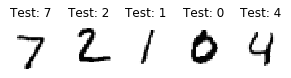

In [59]:
display_digits(plt, X_test_score, y_test_score, 0, 5, 1, 'Test')

As you can see in the results, the predicted labels and the true label are the same - `7`, `2`, `1`, `0`, and `4`.

You can delete the 2 created data assets using the code below.

In [60]:
client.data_assets.delete(client.data_assets.get_uid(asset_details))
client.data_assets.delete(results_uid)

'SUCCESS'

## 7. Summary and next steps <a id="summary"></a>

You successfully completed this notebook! 
 
You learned how to train, evaluate, and score a Keras model. You also learned how to deploy the model in a `.tgz` format via the `watson-machine-learning-client-V4` package.

### Resources <a id="resources"></a>

To learn more about configurations used in this notebook or more sample notebooks, tutorials, documentation, how-tos, and blog posts, check out these links:

<div class="alert alert-block alert-success">

<h4>IBM documentation</h4>
<br>
 <ul>
 <li> <a href="https://wml-api-pyclient-dev-v4.mybluemix.net" target="_blank" rel="noopener no referrer">watson-machine-learning</a></li> 
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/cpd/overview/welcome.html" target="_blank" rel="noopener noreferrer">CP4D 3.0</a></li>
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/deploy-batch-jobs.html" target="_blank" rel="noopener no referrer">Batch Deployments</a></li>
     <ul>
         <li> <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_3.0.0/wsj/wmls/wmls-deploy-python.html#deploy-batch" target="_blank" rel="noopener no referrer">Batch Deployments with the Python client</a></li>
         <li> <a href="https://www.ibm.com/support/knowledgecenter/SSQNUZ_3.0.0/wsj/analyze-data/deploy-batch-details.html" target="_blank" rel="noopener no referrer">Batch Deployment jobs</a></li>
 
<h4> IBM Samples</h4>
<br>
 <li> <a href="https://github.com/IBMDataScience/sample-notebooks" target="_blank" rel="noopener noreferrer">Sample notebooks</a></li>
 
<h4> Others</h4>
<br>
 <li> <a href="https://matplotlib.org" target="_blank" rel="noopener noreferrer">Matplotlib: Python plotting</a></li>
 <li> <a href="https://www.python.org" target="_blank" rel="noopener noreferrer">Official Python website</a><br></li>
 <li> <a href="https://keras.io" target="_blank" rel="noopener noreferrer">Keras: The Python deep learning library</a></li></div>

### Author

**Jihyoung Kim**, Ph.D., is a Data Scientist at IBM who strives to make data science easy for everyone through Watson Studio.

Copyright © 2019, 2020 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>